In [0]:
# Mounting Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Importing Dependencies 
import tensorflow as tf
print("Using TensorFlow version", tf.__version__)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import seaborn as sns
import collections

import cv2, os, glob
from google.colab.patches import cv2_imshow

# Handling OSError: image file is truncated (38 bytes not processed)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

#from mtcnn import MTCNN

Using TensorFlow version 1.15.2


#Defining the Model and Preprocessing Input


In [0]:
# Defining the model 
characters = 5

model = Sequential()

model.add(Conv2D(16, 
                 kernel_size=3, 
                 activation='relu', 
                 kernel_regularizer=l2(0.), 
                 activity_regularizer=l2(0.), 
                 input_shape=(224, 224, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Conv2D(32, 
                 kernel_size=3, 
                 activation='relu', 
                 kernel_regularizer = l2(0.), 
                 activity_regularizer = l2(0.)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, 
                activation='relu', 
                kernel_regularizer = l2(0.), 
                activity_regularizer = l2(0.)))

model.add(Dropout(0.2))

model.add(Dense(characters, activation='softmax'))

In [0]:
# Defining Train & Val sets using generator

train_dir = "/content/drive/My Drive/Stranger Things/Additional DataSet/Train"
val_dir = "/content/drive/My Drive/Stranger Things/Additional DataSet/Val"
image_size = 224
batch = 32
train_images = 5024
val_images = 2102

gen1 = ImageDataGenerator(rotation_range = 30,
            rescale = 1./255)

gen2 = ImageDataGenerator(rescale = 1./255)

train_gen = gen1.flow_from_directory(train_dir, 
                                    target_size = (image_size, image_size), 
                                    batch_size = batch, 
                                    class_mode='categorical')

val_gen = gen2.flow_from_directory(val_dir, 
                                  target_size = (image_size, image_size), 
                                  batch_size = batch, 
                                  class_mode='categorical')

Found 5024 images belonging to 5 classes.
Found 2102 images belonging to 5 classes.


In [0]:
# Compiling the model

n = 50 # No. of Epochs

# Optimizer
sgd = SGD(lr = 0.0001, momentum = 0.9, decay = 0.01/50)
adam = Adam()

model.compile(loss='categorical_crossentropy', 
              optimizer = sgd, 
              metrics=["accuracy"])

# ModelCheckpoint
checkpoint_path = "/content/StrangerFaceNet2.h5"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor = "val_loss", 
                            verbose = 1, 
                             save_best_only = True)

#Training the Model

In [0]:
# Training the Model

history = model.fit_generator(train_gen, 
                              steps_per_epoch = train_images//batch, 
                              epochs = n, 
                              verbose = 1, 
                              callbacks = [checkpoint],
                              validation_data = val_gen,
                              validation_steps = val_images//batch)

Epoch 1/50
 65/157 [===========>..................] - ETA: 27s - loss: 1.0159 - acc: 0.6654
Epoch 00001: val_loss improved from inf to 1.01587, saving model to /content/StrangerFaceNet2.h5
157/157 [==============================] - 166s 1s/step - loss: 0.4806 - acc: 0.8340 - val_loss: 1.0159 - val_acc: 0.6654
Epoch 2/50
 65/157 [===========>..................] - ETA: 26s - loss: 0.8963 - acc: 0.7111
Epoch 00002: val_loss improved from 1.01587 to 0.89625, saving model to /content/StrangerFaceNet2.h5
157/157 [==============================] - 161s 1s/step - loss: 0.4923 - acc: 0.8282 - val_loss: 0.8963 - val_acc: 0.7111
Epoch 3/50
 65/157 [===========>..................] - ETA: 27s - loss: 0.9275 - acc: 0.7043
Epoch 00003: val_loss did not improve from 0.89625
157/157 [==============================] - 159s 1s/step - loss: 0.4772 - acc: 0.8336 - val_loss: 0.9275 - val_acc: 0.7043
Epoch 4/50
 65/157 [===========>..................] - ETA: 26s - loss: 0.8759 - acc: 0.7067
Epoch 00004: val_

In [0]:
# Retriving keys from history.history
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
acc = history.history['acc']
loss = history.history['loss']

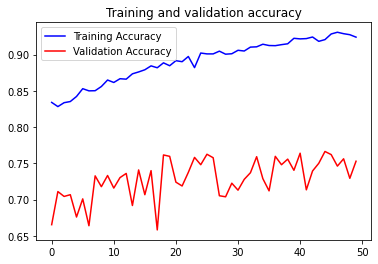

In [0]:
# Graphing the changes between epochs
plt.plot(range(n), acc, 'b', label = 'Training Accuracy')
plt.plot(range(n), val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

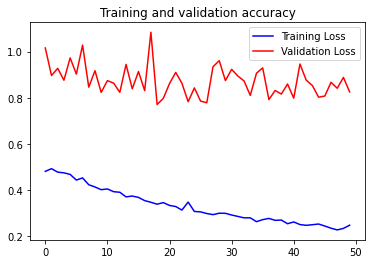

In [0]:
# Graphing the changes between epochs
plt.plot(range(n), loss, 'b', label = 'Training Loss')
plt.plot(range(n), val_loss, 'r', label = 'Validation Loss')
plt.title('Training and validation accuracy')
plt.legend()

#Prediction for a single image

In [0]:
# Loading the saved model

# Defining the path of the saved model
modelPath = "/content/drive/My Drive/StrangerFaceNet_5024_100.h5"

# Loading the saved model as model
model = load_model(modelPath)

In [0]:
# Preprocessing the input Image

# Takes in filePath and returns the processed images that can be fed into model
def preprocessImage(filePath):
  # Reading the image into array using open CV
  imageBgr = cv2.imread(filePath, cv2.IMREAD_COLOR)
  # As CV2 reads image into BGR channel converting into RGB
  imageRgb = cv2.cvtColor(imageBgr, cv2.COLOR_BGR2RGB)
  # Rescaling/Normalizing the input
  rescaledRgb = (1./255)*imageRgb
  # Resizing the input to match image size fed into model: model takes (224*224*3)
  image = cv2.resize(rescaledRgb, (224, 224))
  # Reshaping the input to match input shape of model: model takes (n,224*224*3)
  testImage = image.reshape(1, 224, 224, 3)
  # Returning the processes image to be fed into model and original image in RGB
  return testImage, imageRgb

In [0]:
# Predicting the Image Class

# Takes in preprocessed imgage array and returns predicted class along with it's confidence
def predictImage(inputImage):
  # Using the model to predict 
  predictionArray = model.predict(inputImage)
  # Acessing the confidence of the prediction
  confidence = max(predictionArray[0])*100
  # Processing the prediction to get required index of classes
  index = predictionArray.argmax(axis = 1)[0]
  # Classes on which the model was trained (in the same order)
  classes = ["Finn Wolfhard", "Gaten Matarazzo", "Millie Bobby Brown", "Natalia Dyer", "Noah Schnapp"]
  # Converting the index into actual class
  prediction = classes[index]
  # Returning the predicted class along with it's confidence
  return prediction, confidence 

In [0]:
# Priniting out the prediction result and the image

# Takes in the imagepath and print outs the prediction details along with the image
def printResult(imagePath):
  # Calling preprocessImage to preprocess the image file
  inputImage, image = preprocessImage(imagePath)
  # Calling predictImage to get predicted class and confiidence of prediction
  prediction, confidence = predictImage(inputImage)
  # Rounding off the confidence to 2 decimal places
  confidence = confidence.round(2)
  # Declaring the title
  title = "Image that was predicted by StrangerFaceNet"
  plt.title(title)
  # Displaying out the image into the cell using matplotlib.pyplot 
  plt.imshow(image)
  plt.show()
  # Printing out the prediction details
  print("Predicted:", prediction, "with conficence of", confidence, "%")

In [0]:
# Predicting with a test image using our model
testImagePath = "/content/Eleven.jpg"
printResult(testImagePath)

#Prediction for Images in Batch

In [0]:
# Loading the saved model

# Defining the path of the saved model
modelPath = "/content/drive/My Drive/StrangerFaceNet_5024_100.h5"

# Loading the saved model as model
model = load_model(modelPath)

In [0]:
# Setting up Test Data

test_dir = "/content/drive/My Drive/Stranger Things/Test"
test_gen = gen2.flow_from_directory(test_dir,
                                   target_size = (224, 224), 
                                   class_mode = "categorical", 
                                   shuffle = False)

In [0]:
# Retriving the first test image
test_img = test_gen[0][0][0] 

# Displaying the image
plt.imshow(test_img)

In [0]:
# Prediction
